In [5]:
import os
import sys
base_dir = os.getcwd()
# base_dir = os.path.dirname(current_dir)

# sys.path.append(base_dir)

In [6]:
import pandas as pd
import os
from os import listdir
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
import sklearn.metrics as metrics
from utilities import featurization as fzn
from model import tecrf
import joblib

# The directory contains the dataset that has been divided into train, val, and test data with a 5 fold cross validation scheme
data_url = os.path.join(base_dir, 'data/preprocessed_dataset/5fold_cv')

## Model Evaluation

In [7]:
def reader_dataset(url):
    list_folder = listdir(url)
    list_df = []
    for f in list_folder:
        df_train = pd.read_csv(url+'/'+f+'/train.csv')
        df_val = pd.read_csv(url+'/'+f+'/val.csv')
        df_test = pd.read_csv(url+'/'+f+'/test.csv')
        list_df.append([df_train, df_val, df_test])
    return list_df

def confusion_matrix_calc(actual_, predict_, boundary):
    assert len(actual_)==len(predict_)
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for n in range(len(actual_)):
        if actual_[n]>=boundary and predict_[n]>=boundary:
            TP+=1
        elif actual_[n]<boundary and predict_[n]<boundary:
            TN+=1
        elif actual_[n]>=boundary and predict_[n]<boundary:
            FN+=1
        elif actual_[n]<boundary and predict_[n]>=boundary:
            FP+=1
    return TP, TN, FP, FN

def model_test(train, test, model):
    X_train, y_train, formulae_train = fzn.apply_scheme(train['formula'], list(train['target']))
    X_test, y_test, formulae_test = fzn.apply_scheme(test['formula'], list(test['target']))
    
    scalar = MinMaxScaler()
    X_train_scaled = scalar.fit_transform(X_train)
    X_test_scaled = scalar.transform(X_test)
    print
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    return y_test, y_pred, formulae_test

In [31]:
mae_list = []
pred_list = []
y_list = []
formula_list = []
recall_list = []
precision_list = []
f1_list = []
rmse_list = []
r2_list = []

data_kfold = reader_dataset(data_url) #read data

for d in range(len(data_kfold)):
    train = data_kfold[d][0]
    val = data_kfold[d][1]
    test = data_kfold[d][2]
    
#     model = RandomForestRegressor(random_state = 1, n_estimators= 300, min_samples_split= 5, min_samples_leaf= 2, max_features= 'sqrt', max_depth= 50, bootstrap= False)
#     model = XGBRegressor(random_state = 0, n_estimators= 300, max_depth=7, learning_rate=0.1, colsample_bytree=0.6)
    
#     y_test, y_pred, formulae_test = model_test(train, test, model)

    model = tecrf.TECRF()
    model.train(train, val)
    y_pred = model.predict(test)
    y_test = test['target']
    formulae_test = test['formula']
    
    mae = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)

    mae_list.append(mae)
    r2_list.append(r2)
    rmse_list.append(rmse)
    pred_list.append(list(y_pred))
    y_list.append(list(y_test))
    formula_list.append(list(formulae_test))

    TP, TN, FP, FN = confusion_matrix_calc(y_test, y_pred, -4)
    print('TP={}, TN={}, FP={}, FN={}'.format(TP, TN, FP, FN))
    rec_ = TP/(TP+FN)
    pre_ = TP/(TP+FP)
    f1_score = 2 * (pre_ * rec_) / (pre_ + rec_)
    recall_list.append(rec_)
    precision_list.append(pre_)
    f1_list.append(f1_score)
    
    print('Fold {} - MAE: {} - F1: {}'.format(d+1, mae, f1_score))
    
print('Avg MAE: {} - Avg Recall: {} - Avg Precision: {} - Avg F1: {}'.format(sum(mae_list)/len(mae_list), sum(recall_list)/len(recall_list), sum(precision_list)/len(precision_list), sum(f1_list)/len(f1_list)))
print('Avg R2: {} - Avg RMSE: {}'.format(sum(r2_list)/len(r2_list), sum(rmse_list)/len(rmse_list)))

[2.25748043e-03 1.03478203e-05 9.70493862e-04 1.49506535e-03
 1.54539640e-03 1.41663098e-04 2.11887364e-04 7.78859004e-04
 1.39974617e-03 5.88571958e-04 2.18809030e-03 1.39340148e-03
 1.82967662e-03 7.23458161e-04 8.53632021e-04 5.95253612e-04
 3.83146838e-03 9.30925604e-04 1.84316383e-03 1.15563288e-03
 3.29913174e-03 2.62933087e-03 1.32968044e-03 3.15924685e-03
 8.27199001e-04 7.39971731e-04 2.36303461e-04 3.60856678e-03
 3.17038269e-04 2.63100708e-05 6.57893407e-04 2.81880888e-03
 4.73921896e-04 2.18499204e-03 2.42795977e-05 2.57226426e-03
 2.02871296e-03 1.85094200e-03 3.54490883e-04 4.73187519e-04
 1.38591376e-05 6.61066654e-04 1.22170876e-03 2.56515020e-03
 1.33978863e-03 2.80352708e-05 2.04015863e-03 1.41496712e-03
 1.99434714e-03 2.21449558e-03 1.10433387e-03 1.33119309e-03
 1.88348423e-03 3.39899419e-09 8.03751943e-04 2.26938719e-03
 3.21626564e-03 3.31007793e-04 1.40654969e-03 2.55478243e-05
 1.92501424e-03 1.21549719e-03 2.42075976e-03 1.88248374e-03
 2.74070879e-03 1.566960

(203, 750)
750
TP=88, TN=90, FP=10, FN=15
Fold 1 - MAE: 0.5445072251822831 - F1: 0.8756218905472637
[1.39198619e-03 1.33987985e-03 6.33897650e-04 2.34483013e-03
 2.60251914e-03 9.98454511e-04 8.23920021e-04 4.70411799e-04
 2.81134243e-03 2.38289053e-04 8.37325615e-04 2.90929074e-03
 6.37929174e-04 8.11258153e-04 2.20408659e-03 1.07612940e-03
 1.83148762e-03 1.85309121e-03 1.34241214e-03 6.01790236e-04
 1.61937898e-03 4.25780045e-03 1.59662853e-03 1.76501863e-03
 1.28645191e-03 7.60097064e-04 1.14458443e-03 4.79365094e-04
 8.56750292e-04 1.09857849e-03 2.07904198e-03 8.49456711e-04
 3.21870355e-04 4.02561377e-03 1.46548016e-03 2.01522699e-03
 9.73791653e-04 7.79543184e-04 1.73235772e-03 2.07099049e-03
 2.14431636e-03 2.14115950e-03 1.95070120e-03 8.20063808e-04
 1.81660503e-03 3.89257125e-04 6.90862449e-05 9.24190097e-04
 7.35209815e-04 5.71355928e-04 1.62347883e-03 1.10842504e-03
 7.96520903e-04 1.08792433e-03 1.70375434e-03 6.34792611e-04
 1.39799322e-03 7.60268813e-04 1.70677537e-03 

(203, 750)
750
TP=90, TN=88, FP=12, FN=13
Fold 2 - MAE: 0.5239562398486796 - F1: 0.8780487804878048
[3.71426384e-06 1.36746015e-03 3.62755940e-03 8.19999192e-04
 1.27016481e-03 2.98570410e-03 3.10933212e-05 3.55595693e-03
 1.50203478e-04 2.44243328e-03 1.44512962e-03 7.27985903e-04
 1.55974895e-03 5.40269897e-04 1.31113422e-03 2.99010155e-03
 2.51271705e-03 3.69468704e-04 1.30278411e-05 1.96651080e-03
 1.60419429e-03 1.93042225e-03 9.27210325e-04 1.40036160e-03
 5.68177543e-04 4.12112159e-04 2.06396022e-03 2.02019000e-03
 6.18844243e-04 2.26389808e-03 2.23604516e-03 3.30704687e-03
 2.95537119e-03 1.63542058e-03 1.55646708e-03 1.57114748e-03
 2.74624909e-05 2.27088031e-04 3.07012329e-03 1.39014491e-03
 1.89566460e-03 1.88511348e-03 1.35342194e-03 5.53131424e-04
 5.44750741e-04 9.95446095e-04 5.32390919e-04 1.79834323e-03
 8.02388321e-04 3.30826052e-03 3.01327174e-03 1.19547259e-03
 6.15908896e-04 3.14868857e-03 1.58856748e-03 9.80580290e-04
 2.04951782e-03 2.13508451e-03 7.60080559e-04 

(203, 750)
750
TP=90, TN=87, FP=13, FN=13
Fold 3 - MAE: 0.5180327273737402 - F1: 0.8737864077669902
[7.39748819e-04 3.76949256e-03 1.24880121e-03 2.83503177e-04
 2.88037590e-03 1.88391756e-03 2.05738484e-03 2.32437177e-03
 2.60879793e-03 4.18255070e-04 4.76747648e-04 6.23382474e-04
 2.88014232e-04 1.11824839e-03 2.82733595e-03 1.78294342e-03
 9.84251592e-04 7.58008380e-04 1.69045919e-04 1.08513185e-03
 1.59966433e-03 2.25915030e-03 7.22742083e-05 2.55890342e-03
 1.83833528e-03 1.96317197e-04 2.97040319e-03 5.20718513e-03
 3.54361114e-04 2.77297184e-03 1.67120762e-03 3.03893990e-03
 1.39507764e-03 1.47583017e-03 4.90087576e-04 9.70221647e-04
 7.80083866e-05 3.02089669e-03 1.65073781e-03 9.44197742e-04
 3.71100107e-03 5.14576720e-03 1.09354904e-03 1.11941067e-03
 3.35705979e-03 1.05703321e-03 2.40671107e-03 1.66671902e-03
 1.08035378e-03 1.73310080e-03 1.20503656e-03 1.88595979e-03
 1.13990813e-03 6.91028086e-04 1.67465068e-03 2.17989892e-03
 9.36974104e-04 2.78746356e-03 1.78075462e-03 

(203, 750)
750
TP=91, TN=86, FP=14, FN=12
Fold 4 - MAE: 0.5368143582770424 - F1: 0.8750000000000001
[5.39746344e-04 9.06233973e-04 3.89965210e-04 8.36426482e-04
 3.52762461e-03 2.73891565e-05 8.04783323e-04 2.56283344e-05
 1.78858499e-03 4.41916840e-05 2.09232449e-04 3.49316855e-03
 5.72164877e-06 2.66513803e-04 1.05304008e-06 2.81075622e-03
 5.25021826e-05 1.58871656e-03 1.38527606e-03 7.34036719e-04
 3.23629755e-04 5.87304757e-03 2.53654555e-04 2.06400700e-03
 4.18015772e-04 5.45861011e-06 9.85076959e-04 6.29830773e-06
 1.31511941e-03 1.40256944e-05 2.08282359e-04 1.86789242e-04
 1.69248379e-03 4.24817768e-03 4.97140166e-04 7.83515996e-04
 6.09927478e-07 5.78654460e-05 2.51475348e-03 4.05010597e-03
 3.01536810e-04 8.34867379e-04 1.79902094e-03 4.46044056e-04
 4.05243320e-03 6.39568696e-04 1.80877769e-03 1.22282496e-03
 1.17917273e-03 6.08816377e-04 8.39112741e-04 4.69329934e-03
 1.51186558e-03 9.33616231e-05 2.43696297e-03 1.27433647e-03
 2.30024368e-04 6.73382063e-04 4.20606133e-05 

(203, 750)
750
TP=92, TN=88, FP=12, FN=11
Fold 5 - MAE: 0.5277552631986342 - F1: 0.8888888888888888
Avg MAE: 0.5302131627760758 - Avg Recall: 0.8757281553398059 - Avg Precision: 0.8810761167797964 - Avg F1: 0.8782691935381894
Avg R2: 0.6596119732320936 - Avg RMSE: 0.8913389937636322


## Training


In [32]:
train = pd.read_csv(data_url+'/1/train.csv')
val = pd.read_csv(data_url+'/1/val.csv')
test = pd.read_csv(data_url+'/1/test.csv')
trainnval = pd.concat([train, val]).reset_index()

model = tecrf.TECRF()
model.train(trainnval, test)

model_url = os.path.join(base_dir, 'model.joblib')
joblib.dump(model, model_url)

[7.11403070e-05 5.27803301e-04 3.17265588e-04 2.46566265e-03
 2.36360715e-03 2.19721058e-03 8.63435569e-05 1.71992229e-03
 1.70334209e-03 2.07625154e-03 9.27543097e-04 3.53458100e-03
 2.60974304e-03 1.58739950e-04 3.97087475e-03 1.94115579e-03
 3.21737431e-03 1.47116001e-03 3.78063801e-03 1.16495342e-04
 4.16293564e-04 1.42731363e-03 3.17851989e-03 3.41372688e-03
 2.45158405e-03 3.95632363e-04 7.80310963e-05 2.53788702e-03
 1.50704520e-03 2.54390160e-03 6.61397815e-04 1.91199885e-03
 6.25431171e-04 2.72373057e-04 6.86529983e-04 3.76357041e-03
 2.44279354e-03 1.97372721e-03 1.74767966e-03 2.28035454e-04
 3.62135058e-05 1.96270556e-03 1.06365282e-03 1.70149673e-05
 2.36499367e-04 1.30355809e-03 3.02344621e-03 7.39651111e-04
 2.34059072e-03 2.96630045e-03 5.17250336e-04 2.30071133e-03
 2.16107842e-03 1.18724907e-03 1.36440819e-03 4.34713732e-04
 3.19211082e-03 1.53953263e-06 6.52460018e-04 5.07214512e-04
 9.73162016e-04 1.13383116e-04 9.91416761e-07 1.76027625e-03
 3.74779358e-03 8.274433

['D:\\GITHUB\\ML_SSE\\model.joblib']

## Predict new data

In [33]:
list_data = ['Li10.2(Te0.2Si0.8)1.2P1.8S12',
'Li10.2(Ti0.2Si0.8)1.2P1.8S12',
'Li10.2(Zr0.2Si0.8)1.2P1.8S12',
'Li49.6Ti1.6La24Zr14.4Nb1.6O96',
'Li6.75La3Zr1.75Nb0.25O12',
'(Li0.39La0.54)1.01In0.02Ti0.98O3',
'Li6.175P0.825Si0.175S5Cl',
'Li0.5La0.5Ti0.96Tb0.04O3',
'Li6.4La3Zr1.7W0.3O12',
'Li6.025P0.975Si0.025S5Cl',
'Li2.633Eu0.633Mo0.367Cl6',
'Li2.633Y0.633Zr0.367Cl6',
'Li2.633Tb0.633Zr0.367Cl6',
'Li6.25In0.2La3Zr2O12',
'Li2.633Dy0.633Ti0.367Cl6',
'Li6.6La2.875Dy0.125Zr1.6Ta0.4O12',
'Li6.6La2.875Sm0.125Zr1.6Ta0.4O12',
'Li2.633Sm0.633Zr0.367Cl6',
'Li2.633Gd0.633Ti0.367Cl6',
'(Li0.39La0.54)1.01Mo0.02Ti0.98O3',]


In [34]:
# new_data = pd.read_csv(os.path.join(base_url, 'element_substitution/new_formula.csv'))

dummy_target = [0]*len(list_data)
new_data = pd.DataFrame({'formula': list_data, 'target': dummy_target})

In [35]:
model = joblib.load(model_url)

prediction = model.predict(new_data)
df_predict = pd.DataFrame({'formula': new_data['formula'], 'prediction':prediction})
df_predict

(20, 750)
750


,formula,prediction
0,Li10.2(Te0.2Si0.8)1.2P1.8S12,-2.671088
1,Li10.2(Ti0.2Si0.8)1.2P1.8S12,-3.161086
2,Li10.2(Zr0.2Si0.8)1.2P1.8S12,-3.034017
3,Li49.6Ti1.6La24Zr14.4Nb1.6O96,-3.467846
4,Li6.75La3Zr1.75Nb0.25O12,-3.179647
5,(Li0.39La0.54)1.01In0.02Ti0.98O3,-3.263494
6,Li6.175P0.825Si0.175S5Cl,-3.533209
7,Li0.5La0.5Ti0.96Tb0.04O3,-3.774983
8,Li6.4La3Zr1.7W0.3O12,-3.313679
9,Li6.025P0.975Si0.025S5Cl,-3.682327


<AxesSubplot:>

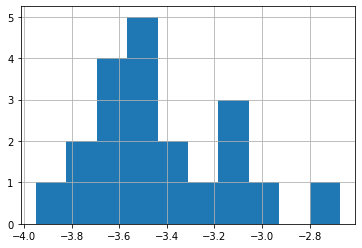

In [36]:
df_predict['prediction'].hist()

In [37]:
# df_predict.to_csv(os.path.join(base_url, 'new_formula_prediction.csv'))